# Preliminary analysis of RCA in vitro trials

In [54]:
import os, sys
import tifffile as tif
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

import cv2
import skimage
import scipy.ndimage, scipy.stats

## Crop and save images

In [2]:
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging"

# list of all files in the directory
files = os.listdir(data_dir)
files = [os.path.join(data_dir, f) for f in files if f.endswith('.tif')]
files.sort()
files

['/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging/1000_dilution_100x_488nm.tif',
 '/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250411_RCA_fluo_imaging/1000_dilution_100x_555nm.tif']

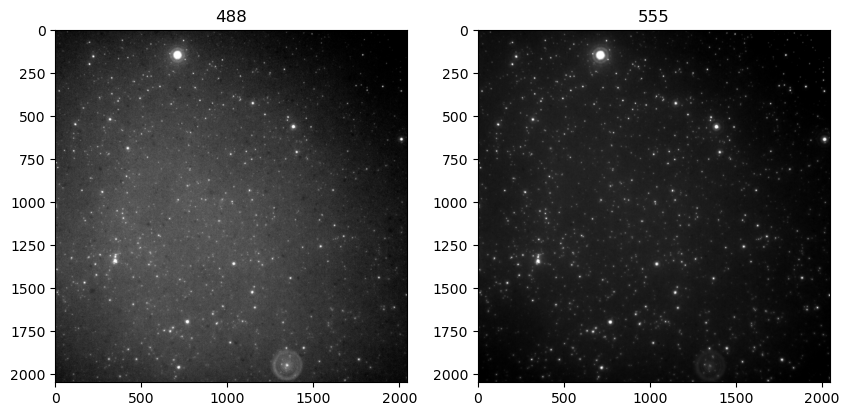

In [4]:
img_488 = tif.imread(files[0])
img_555 = tif.imread(files[1])


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.title("488")
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.title("555")
plt.show()

Plot a line profile in the diagonal direction

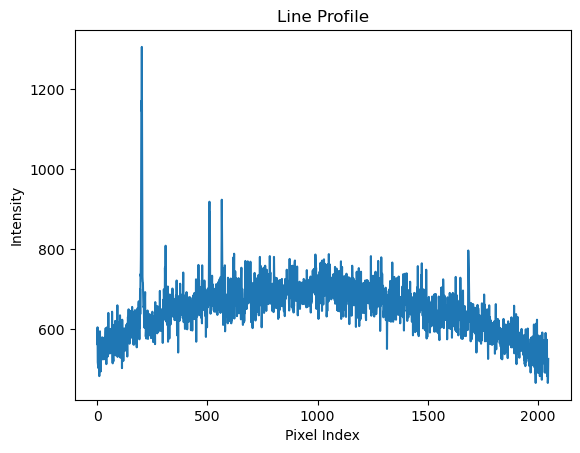

In [5]:
def plot_line_profile(img, start, end):
    # Create a mask for the line
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.line(mask, start, end, 255, 1)

    # Get the coordinates of the line
    coords = np.column_stack(np.where(mask > 0))

    # Get the pixel values along the line
    line_values = img[coords[:, 0], coords[:, 1]]

    # Plot the line profile
    plt.plot(line_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Line Profile')
    plt.show()
# Define the start and end points of the line
start = (0, 0)
end = (img_488.shape[1] - 1, img_488.shape[0] - 1)
# Plot the line profile for the first image
plot_line_profile(img_488, start, end)

Try background removal

In [6]:
def vis_roll_ball(img, radius):
    # slightly blur the image to remove noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # rolling ball algorithm to remove background
    background = skimage.restoration.rolling_ball(img, radius=radius)
    img_sub = img - background
    
    # set figure size
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.clim(np.percentile(img, 5), np.percentile(img, 99.9))
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(background, cmap='gray')
    plt.title('Background')
    plt.clim(np.percentile(background, 5), np.percentile(background, 99.9))
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(img_sub, cmap='gray')
    plt.title('Subtracted Image')
    plt.clim(np.percentile(img_sub, 5), np.percentile(img_sub, 99.9))
    plt.axis('off')

    plt.show()

    start = (0, 0)
    end = (img_sub.shape[1] - 1, img_sub.shape[0] - 1)
    plot_line_profile(img_sub, start, end)
    
def vis_gaussian(img, sigma1, sigma2):
    # difference of guassian sigma1 = 2, sigma2 = 10
    img_sig1 = skimage.filters.gaussian(img, sigma=sigma1, preserve_range=True)
    img_sig2 = skimage.filters.gaussian(img, sigma=sigma2, preserve_range=True)
    img_sub = img_sig1 - img_sig2
    
    return img_sub

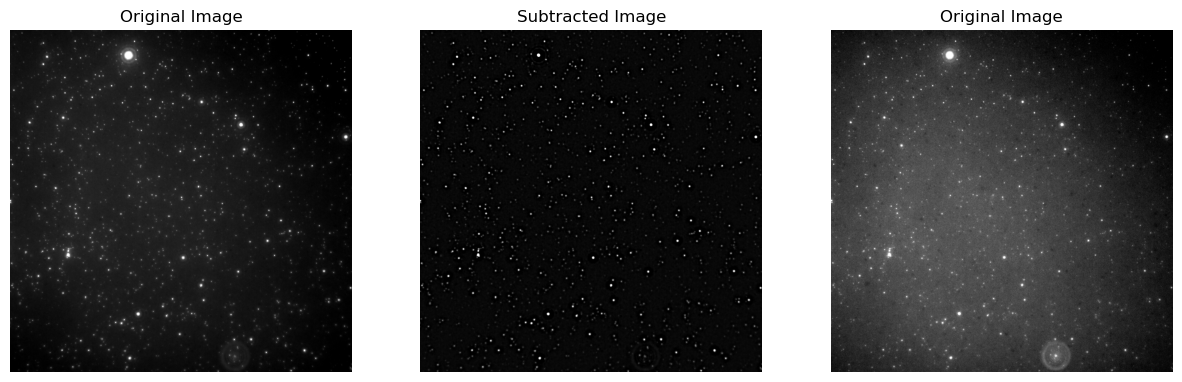

In [7]:
img_555_sub = vis_gaussian(img_555, 2, 10)
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img_555, cmap='gray')
plt.title('Original Image')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
plt.subplot(132)
plt.imshow(img_555_sub, cmap='gray')
plt.title('Subtracted Image')
plt.clim(np.percentile(img_555_sub, 5), np.percentile(img_555_sub, 99.9))
plt.axis('off')
plt.subplot(133)
plt.imshow(img_488, cmap='gray')
plt.title('Original Image')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
plt.show()

Local max (circular kernel)

In [16]:
def maximum_filter(img, radius):
    # set a circular kernel
    kernel = cv2.circle(np.zeros((radius*2+1, radius*2+1), dtype=np.uint8), (radius, radius), radius, 1, -1)
    
    # apply the maximum filter using the circular kernel, consider a reflective border
    img_max = cv2.dilate(img, kernel, iterations=1)
    return img_max

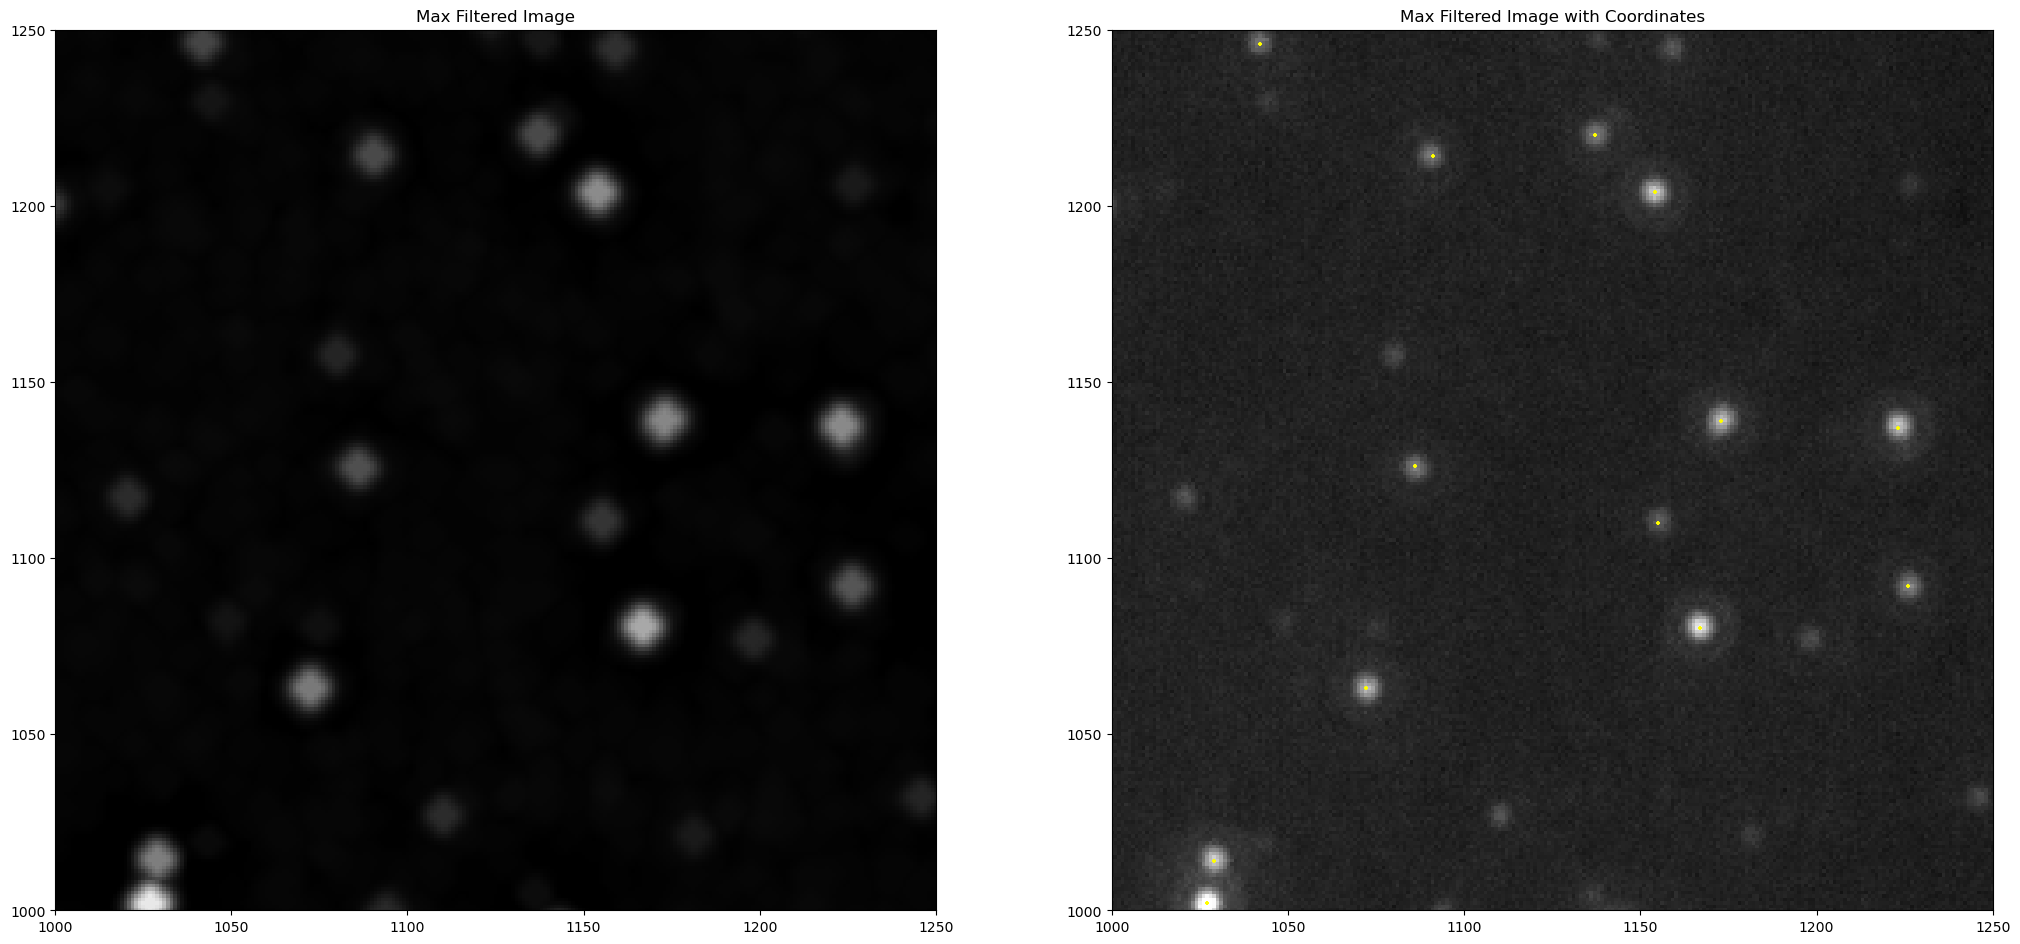

In [46]:
# img_555_max = scipy.ndimage.maximum_filter(img_555_sub, size=5)
img_555_max = maximum_filter(img_555_sub, radius=2)
thres = 500
coordinates = skimage.feature.peak_local_max(img_555_sub, min_distance=5, threshold_abs=thres)

plt.figure(figsize=(25, 15))
plt.subplot(121)
plt.imshow(img_555_max, cmap='gray')
plt.title('Max Filtered Image')
plt.clim(np.percentile(img_555_max, 5), np.percentile(img_555_max, 99.9))
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)
# plt.colorbar()

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('Max Filtered Image with Coordinates')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))

# plt.colorbar()
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
    
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)
    
plt.show()

Coarse peak intensity correlation

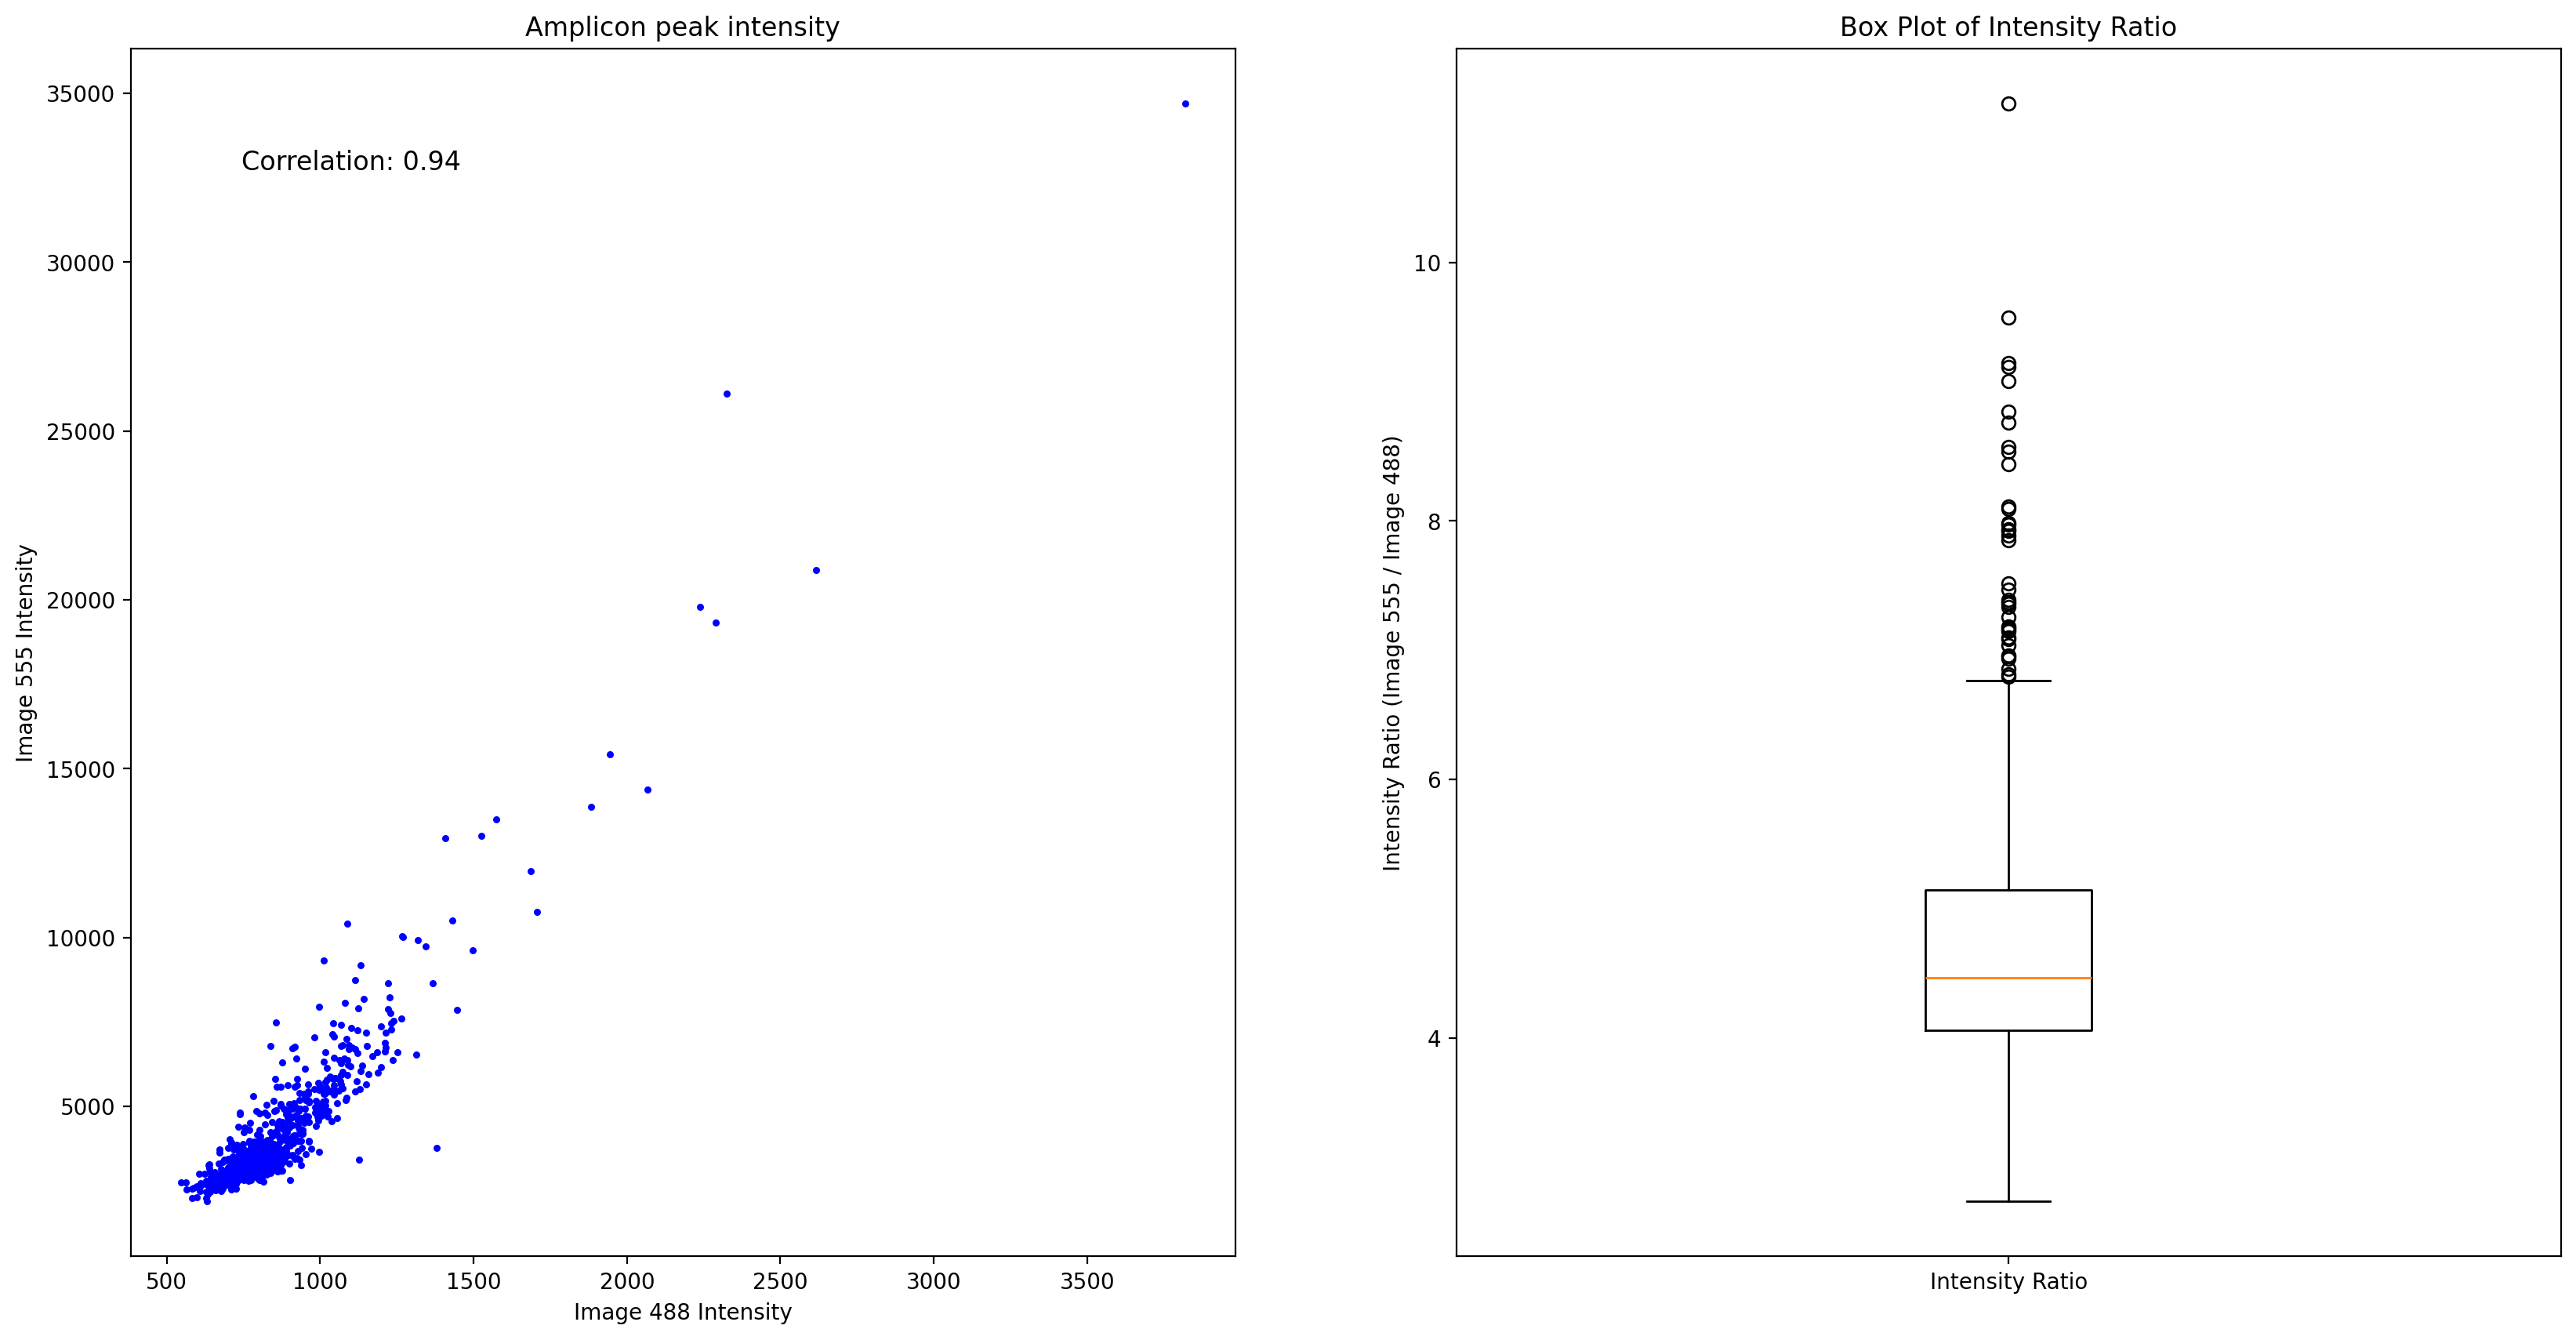

In [47]:
# plot a scatter plot correlating the intensity of img_488 and img_555 in the same coordinates
def plot_scatter(img1, img2, coordinates):
    # Get the pixel values at the coordinates
    values1 = img1[coordinates[:, 0], coordinates[:, 1]]
    values2 = img2[coordinates[:, 0], coordinates[:, 1]]

    # remove data pair if any of them is higher than 60000
    mask = (values1 < 60000) & (values2 < 60000)
    values1 = values1[mask]
    values2 = values2[mask]
    
    # ratio
    ratio = values2/values1
    
    # Plot the scatter plot
    plt.figure(figsize=(20, 10), dpi = 200)
    plt.subplot(121)
    plt.scatter(values1, values2, c='blue', s=5)
    plt.xlabel('Image 488 Intensity')
    plt.ylabel('Image 555 Intensity')
    plt.title('Amplicon peak intensity')
    # compute the correlation coefficient
    correlation = np.corrcoef(values1, values2)[0, 1]
    plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
    
    plt.subplot(122)
    # plot a box plot
    plt.boxplot(ratio)
    plt.ylabel('Intensity Ratio (Image 555 / Image 488)')
    plt.title('Box Plot of Intensity Ratio')
    plt.xticks([1], ['Intensity Ratio'])
    
    plt.show()
    
    
    
# Convert coordinates to a numpy array
coordinates = np.array(coordinates)
# Plot the scatter plot
plot_scatter(img_488, img_555, coordinates)

whole-amplicon intensity correlation

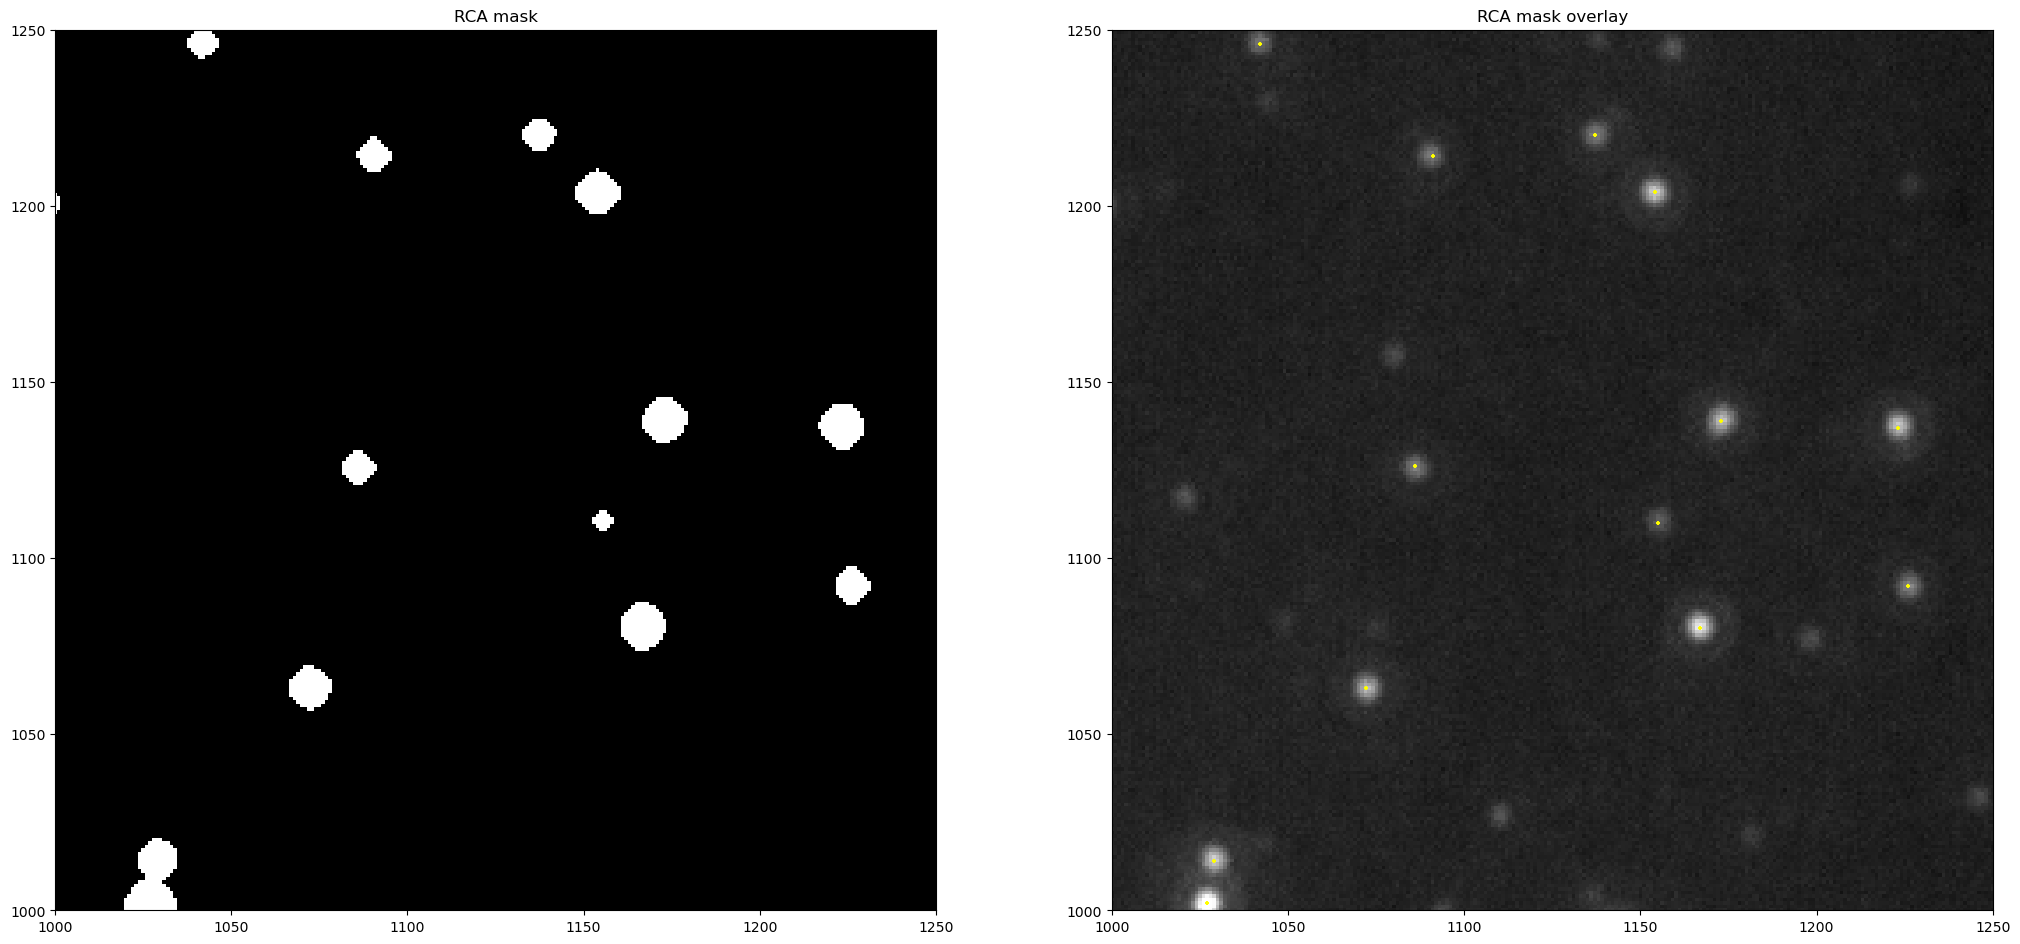

In [48]:
img_mask = img_555_max > thres

plt.figure(figsize=(25, 15))
plt.subplot(121)
plt.imshow(img_mask, cmap='gray')
plt.title('RCA mask')
plt.clim(0, 1)
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)

plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('RCA mask overlay')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.xlim(1000, 1250)
plt.ylim(1000, 1250)
plt.show()

In [49]:
# turn the mask into a label image
img_mask = skimage.measure.label(img_mask)
img_488_df = skimage.measure.regionprops_table(img_mask, img_488, properties=['label', 'area', 'mean_intensity'])
img_555_df = skimage.measure.regionprops_table(img_mask, img_555, properties=['label', 'area', 'mean_intensity'])

In [50]:
img_488_df = pd.DataFrame(img_488_df)
img_555_df = pd.DataFrame(img_555_df)

# add one column to store area*mean_intensity as total_intensity
img_488_df['total_intensity'] = img_488_df['area'] * img_488_df['mean_intensity']
img_555_df['total_intensity'] = img_555_df['area'] * img_555_df['mean_intensity']
# merge the two dataframes on label
img_df = pd.merge(img_488_df, img_555_df, on='label', suffixes=('_488', '_555'))

img_df

,label,area_488,mean_intensity_488,total_intensity_488,area_555,mean_intensity_555,total_intensity_555
0,1,71.0,651.140845,46231.0,71.0,2511.281690,178301.0
1,2,43.0,695.325581,29899.0,43.0,2630.116279,113095.0
2,3,62.0,591.645161,36682.0,62.0,2503.983871,155247.0
3,4,37.0,565.135135,20910.0,37.0,2066.810811,76472.0
4,5,76.0,629.960526,47877.0,76.0,2442.552632,185634.0
...,...,...,...,...,...,...,...
722,723,86.0,703.872093,60533.0,86.0,2432.116279,209162.0
723,724,168.0,707.976190,118940.0,168.0,2911.964286,489210.0
724,725,49.0,686.000000,33614.0,49.0,2390.408163,117130.0
725,726,107.0,712.514019,76239.0,107.0,2676.663551,286403.0


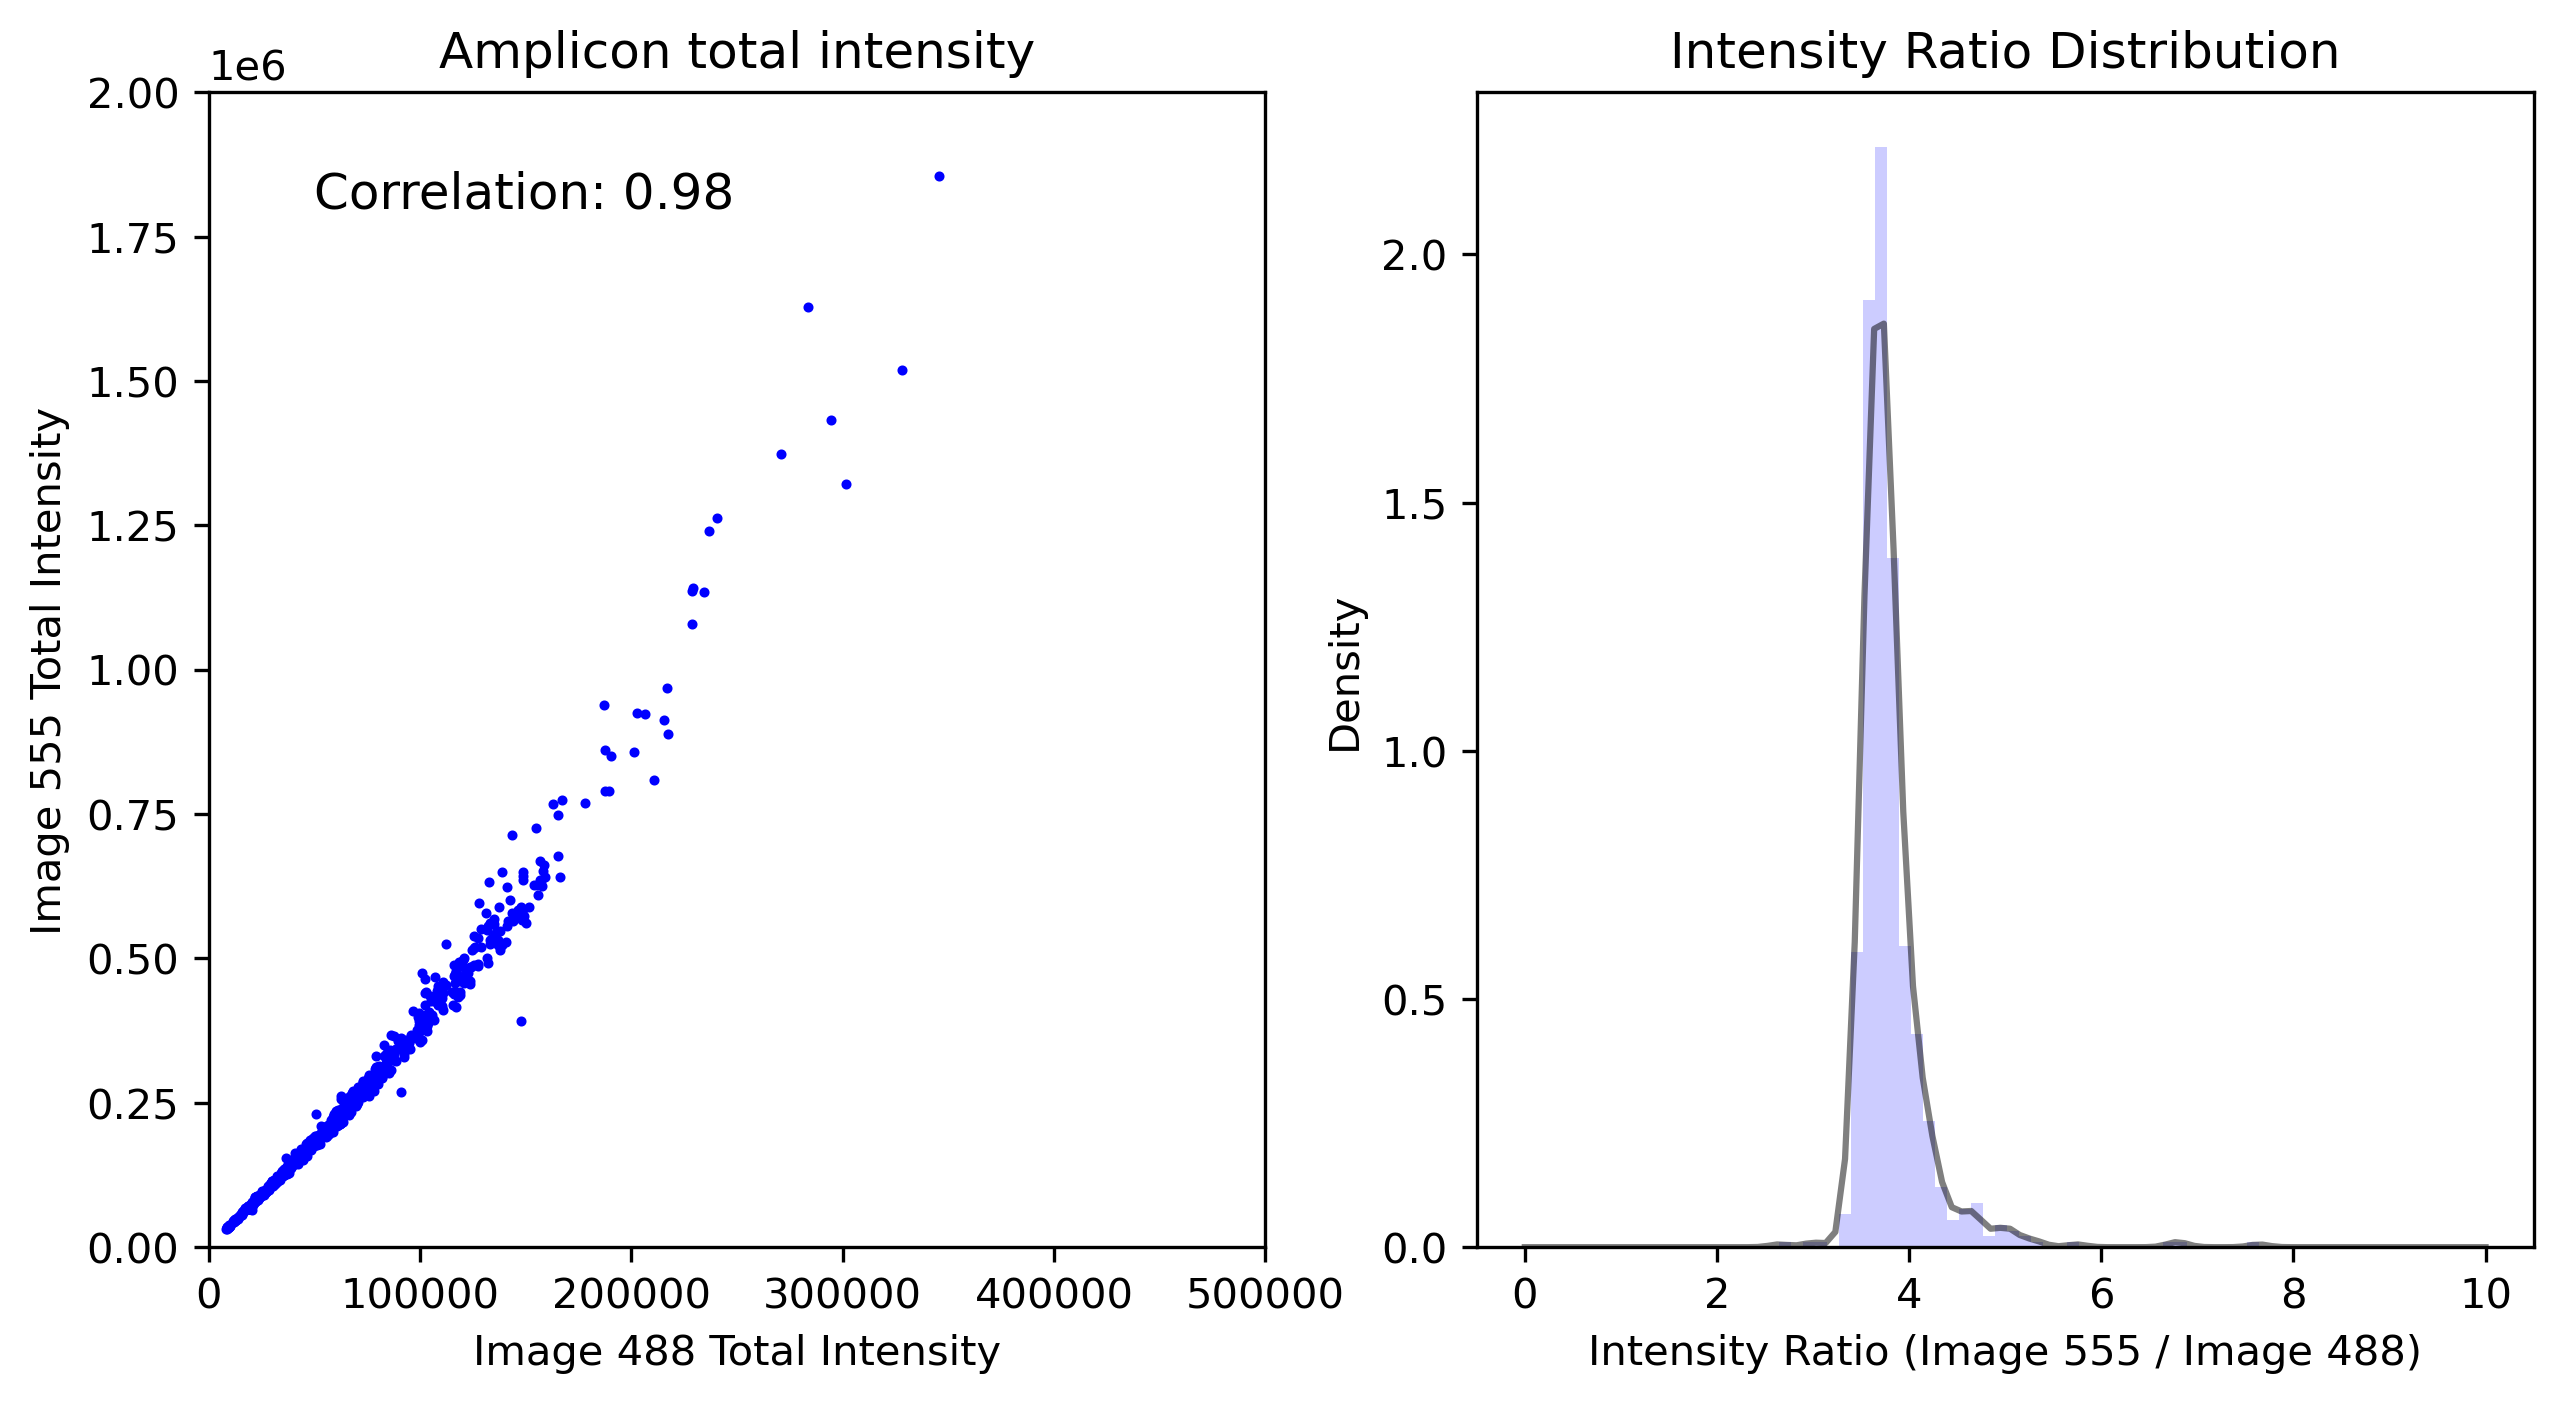

In [68]:
# plot scatter plot of total intensity
plt.figure(figsize=(10, 5), dpi = 300)
plt.subplot(121)
plt.scatter(img_df['total_intensity_488'], img_df['total_intensity_555'], c='blue', s=2)
plt.xlabel('Image 488 Total Intensity')
plt.ylabel('Image 555 Total Intensity')
plt.title('Amplicon total intensity')
# compute the correlation coefficient
correlation = np.corrcoef(img_df['total_intensity_488'], img_df['total_intensity_555'])[0, 1]
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlim(0, 0.5e6)
plt.ylim(0, 2e6)
# turn on log scale
# plt.xscale('log')
# plt.yscale('log')
plt.subplot(122)
# plot a smoothened histogram of the intensity ratio
plt.hist(img_df['total_intensity_555']/img_df['total_intensity_488'], bins=40, density=True, alpha=0.2, color='blue')
kde = scipy.stats.gaussian_kde(img_df['total_intensity_555']/img_df['total_intensity_488'])
x = np.linspace(0, 10, 100)
plt.plot(x, kde(x), color='black', alpha=0.5)
plt.xlabel('Intensity Ratio (Image 555 / Image 488)')
plt.ylabel('Density')
plt.title('Intensity Ratio Distribution')
plt.show()

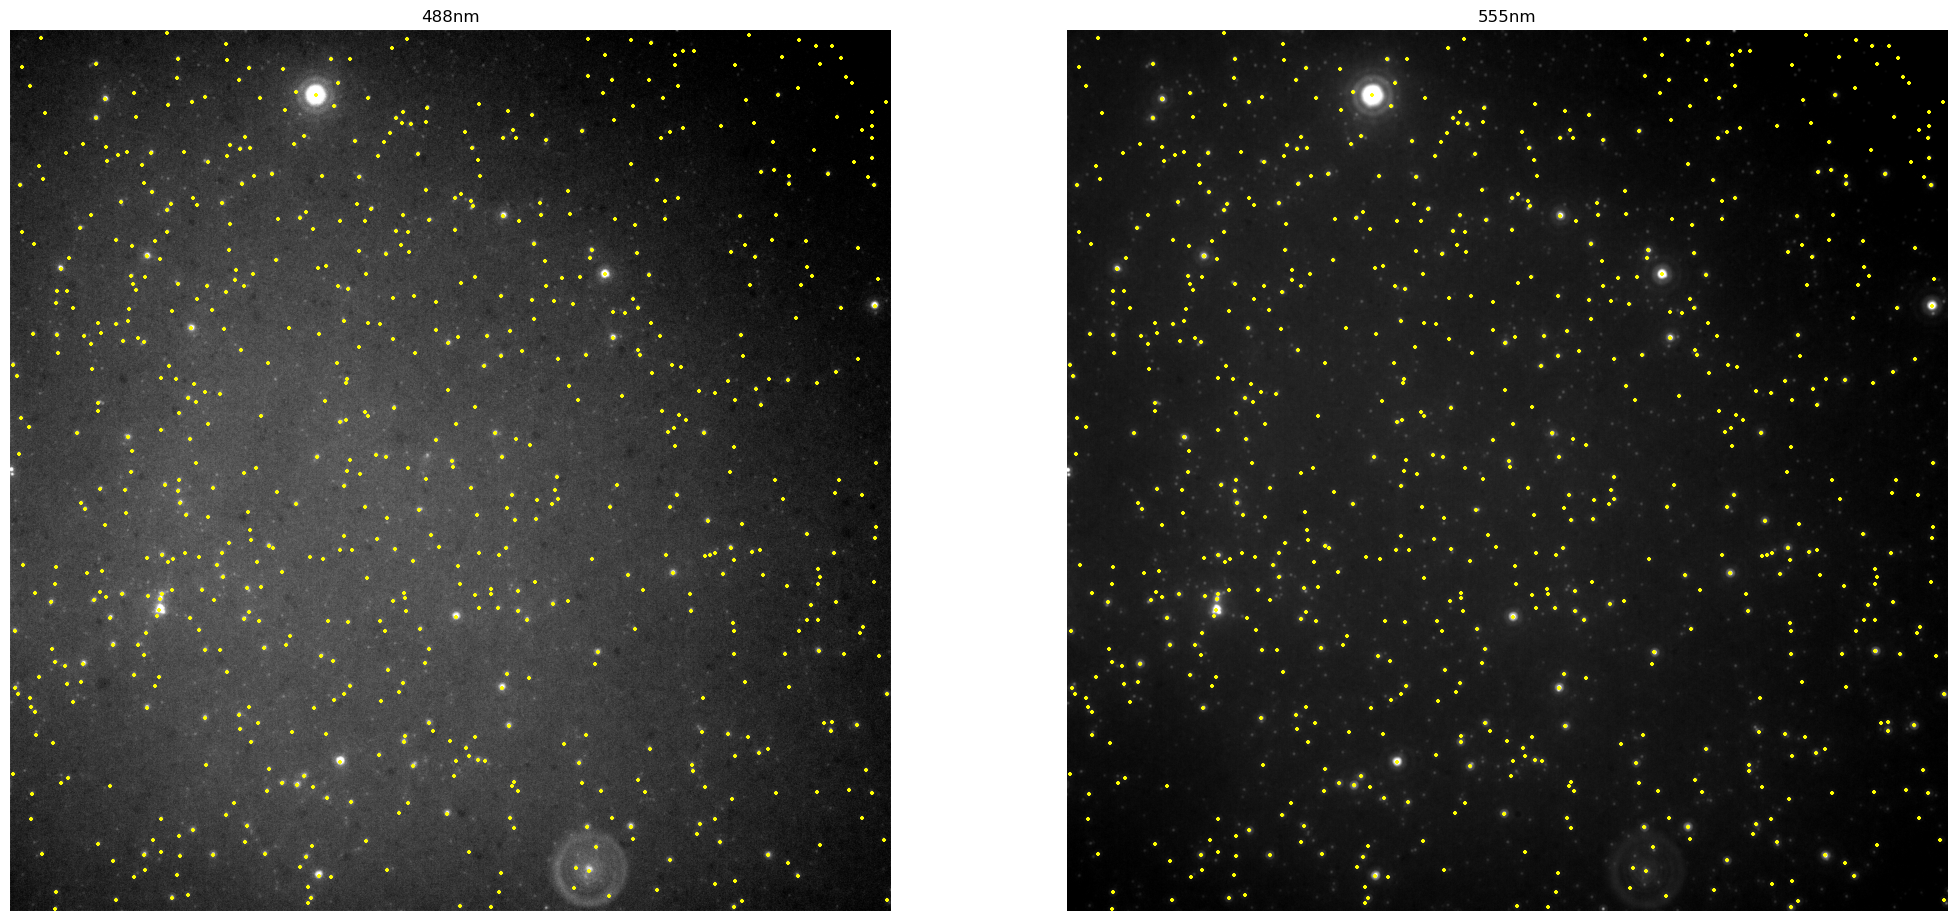

In [27]:
# plot 488 and 555 raw image overlaid with the coordinates
plt.figure(figsize=(25, 15))
plt.subplot(121)
plt.imshow(img_488, cmap='gray')
plt.title('488nm')
plt.clim(np.percentile(img_488, 5), np.percentile(img_488, 99.9))
plt.axis('off')
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.subplot(122)
plt.imshow(img_555, cmap='gray')
plt.title('555nm')
plt.clim(np.percentile(img_555, 5), np.percentile(img_555, 99.9))
plt.axis('off')
# overlay the coordinates on the image
for coord in coordinates:
    plt.scatter(coord[1], coord[0], c='yellow', s=12, marker = '+')
plt.show()